In [2]:
import numpy as np             
import sounddevice as sd        #importamos sounddevice paquete para la reproduccion y grabacion de audio 
from scipy.io import wavfile    #modulo para lecto-escritura de archivos .wav
import matplotlib.pyplot as plt

In [4]:
from acousticfield.generate import sweep
from acousticfield.process import play_rec, ir_extract

In [5]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (Realtek(R) Audio), MME (2 in, 0 out)
   2 Microphone (Logitech BRIO), MME (2 in, 0 out)
   3 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  4 Speakers (Realtek(R) Audio), MME (0 in, 8 out)
   5 S23C350 (NVIDIA High Definition, MME (0 in, 2 out)
   6 Nx Headphones (Waves Virtual Au, MME (0 in, 8 out)
   7 Realtek Digital Output (Realtek, MME (0 in, 2 out)
   8 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   9 Microphone (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  10 Microphone (Logitech BRIO), Windows DirectSound (2 in, 0 out)
  11 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  12 Speakers (Realtek(R) Audio), Windows DirectSound (0 in, 8 out)
  13 S23C350 (NVIDIA High Definition Audio), Windows DirectSound (0 in, 2 out)
  14 Nx Headphones (Waves Virtual Audio Device), Windows DirectSound (0 in, 8 out)
  15 Realtek Digital Output (Realtek(R) Audio), Windows DirectSound

In [6]:
sd.default.device = [2,4]

In [7]:
sweep1 = sweep(T=10.0,fs=48000,f1=30,f2=22000,filename='sweep10s_30_22k')

In [8]:
rec_1 = play_rec('sweep10s_30_22k','rec_L1D1M1') 

listo


In [10]:
ri_1 = ir_extract(rec_1,'sweep10s_30_22k','ri_1')

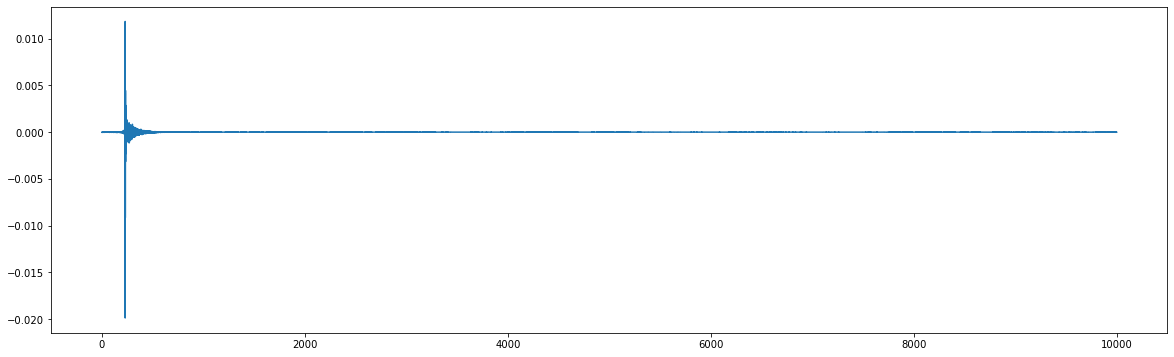

In [11]:
nsamples = len(ri_1)
fs=48000            
t = np.arange(nsamples)/fs*1000   
plt.figure(figsize=(20,6))
plt.plot(t,ri_1,alpha=1)   